This notebook evaluates the results form the user study. Set `FILL_DATABASE` to True to create a mock database. Set it to False to use the results from an existing database.

If mocking data, this notebook expects the server to run on `server_url` with a database with no entries, as set up by running `node setup.mjs`. 

In [1]:
USER_STUDY_CSV = "./results/user_study/selection.csv"
SQLITE_DB = "../survey/db_final.db"
FILL_DATABASE = False # if True, data is mocked, THIS CALLS THE APIs

server_url = "http://localhost:3002" # server to mock data on


In [2]:

import krippendorff
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
import numpy as np 
import scipy.stats as stats 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import sqlite3
import pandas as pd
connection = sqlite3.connect(SQLITE_DB)

user_df = pd.read_sql_query("SELECT * FROM users", connection)

In [4]:
df_user_study = pd.read_csv(USER_STUDY_CSV)

## Fill Database
If `FILL_DATABASE` is True

In [5]:
%%writefile run_user.py

def run_user(idx, user, url, df_user_study):
    n_learn = 16
    n_eval = 16
    n_users = 10

    mu_got_it_right_pre=0.5
    sigma_got_it_right_pre=0.05
    mu_gain = 0.2
    sigma_gain = 0.1

    def guess(detector_label,p):
        return detector_label if bool(np.random.choice([0,1],p=[1-p, p])) else not detector_label

    import requests
    import json
    import numpy as np
    import pandas as pd
    user_dist_without = lambda : np.clip(np.random.normal(mu_got_it_right_pre, sigma_got_it_right_pre, 1)[0], 0,1)
    user_dist_gain = lambda : np.clip(np.random.normal(mu_gain, sigma_gain, 1)[0], -1,1)
  
    res = requests.get(url+"/auth/"+ user["access_token"])

    print(res.text)
    auth_token = json.loads(res.text)
    headers = {'Content-Type': 'application/json','Authorization': "Bearer "+auth_token, "Content-Type": "application/json",}

    requests.post(url+"/api/submitParticipantInfo", json={
    "has_seen_explanation_methods_before": "yes",
    "has_seen_OTHERS_before": "yes",
    "level_of_expertise": "is-researcher-explainability",
    "familiarity_with_chatgpt": "occasional-use",
    "prefers_monochromatic_methods": "yes" if idx % 20 == 0 else "no"
    }, headers=headers)
    # go to phase 2
    requests.post(url+"/api/completeCurrentPhase", json={"expected": 0}, headers=headers)
    # if idx % 8 == 0:
    #     return
    requests.post(url+"/api/completeCurrentPhase", json={"expected": 1}, headers=headers)
    requests.post(url+"/api/completeCurrentPhase", json={"expected": 2}, headers=headers)

    res = requests.get(url+"/api/state", headers=headers)
    state = json.loads(res.text)

    # user_df = pd.read_sql_query("SELECT * FROM users", connection) # update as group is assigned now
    # user = user_df.iloc[idx]
   # print(user[["detector", "explainer"]])
    # return state
    df_user_documents = df_user_study.loc[df_user_study.groupby("Detector").groups[state["detector"]],:].reset_index(drop=True)
    for doc_nr, row in df_user_documents.iterrows():
        p_without = user_dist_without()
        requests.post(url+"/api/submitPhase2", json={"ID": doc_nr, "label": guess(row["f(b)"], p_without)}, headers=headers)
    requests.post(url+"/api/completeCurrentPhase", json={"expected": 3}, headers=headers)

    for doc_nr, row in df_user_documents.iterrows():
        json_ = {"lickert-q{}-{}".format(question_nr, doc_nr): str(np.random.choice([1,2,3,4,5], p=[0.1,0.2,0.1,0.4,0.2])) for question_nr in range(1,4)}
        json_["document_nr"] = doc_nr
        requests.post(url+"/api/submitPhase3", json=json_, headers=headers)

    requests.post(url+"/api/completeCurrentPhase", json={"expected": 4}, headers=headers)
    for doc_nr, row in df_user_documents.iterrows():
        p_with = np.clip(p_without + user_dist_gain(), 0,1)
        requests.post(url+"/api/submitPhase4", json={"ID": doc_nr, "label": guess(row["f(b)"], p_with)}, headers=headers)
    requests.post(url+"/api/completeCurrentPhase", json={"expected": 5}, headers=headers)


Overwriting run_user.py


In [6]:
from tqdm import tqdm
from multiprocess import Pool
from run_user import run_user


if FILL_DATABASE:
    max_pool = 10
    mock_user_data = [(idx, user, server_url, df_user_study) for idx, user in user_df.iterrows() if idx < 27]

    with Pool(max_pool) as p:
        pool_outputs = list(tqdm(p.starmap(run_user,mock_user_data),total=len(mock_user_data)))    
    print(pool_outputs)


## Evaluation
### Participant Info

In [7]:
participant_info = pd.read_sql_query("SELECT participant_info.*, users.detector, users.explainer FROM participant_info INNER JOIN users ON participant_info.user_id = users.ID where users.current_phase = 5", connection)
participant_info.head(1)

,user_id,has_seen_explanation_methods_before,has_seen_SHAP_before,has_seen_LIME_before,has_seen_ANCHOR_before,has_seen_OTHERS_before,level_of_expertise,familiarity_with_chatgpt,prefers_monochromatic_methods,detector,explainer
0,1,yes,None,None,None,None,is-researcher,is-researcher-generative-lms,no,DetectorDetectGPT,SHAP_Explainer


In [8]:
stat = lambda col_name : display(participant_info[col_name].value_counts(normalize=True).round(2))

In [9]:
stat("level_of_expertise")

level_of_expertise
has-taken-course                0.50
no-experience                   0.24
is-researcher                   0.21
is-researcher-explainability    0.05
Name: proportion, dtype: float64

In [10]:
stat("familiarity_with_chatgpt")

familiarity_with_chatgpt
occasional-use                  0.45
frequent-use                    0.34
is-researcher-generative-lms    0.18
never-used                      0.03
Name: proportion, dtype: float64

In [11]:
stat("has_seen_explanation_methods_before")

has_seen_explanation_methods_before
no     0.76
yes    0.24
Name: proportion, dtype: float64

### Forward Simulation

There are two more users for Guo+SHAP and Radford+Anchor:

In [12]:
user_df = pd.read_sql_query("SELECT * FROM users where current_phase = 5", connection) # remove the two last 
user_df.groupby(["detector", "explainer"])["ID"].count()

detector           explainer       
DetectorDetectGPT  Anchor_Explainer    4
                   LIME_Explainer      4
                   SHAP_Explainer      4
DetectorGuo        Anchor_Explainer    4
                   LIME_Explainer      4
                   SHAP_Explainer      5
DetectorRadford    Anchor_Explainer    5
                   LIME_Explainer      4
                   SHAP_Explainer      4
Name: ID, dtype: int64

Exclude the last two:

In [13]:
user_df = pd.read_sql_query("SELECT * FROM users where current_phase = 5 and users.id != 76 and users.id != 45", connection) # remove the two last 

In [14]:
user_df.groupby(["detector", "explainer"])["ID"].count()

detector           explainer       
DetectorDetectGPT  Anchor_Explainer    4
                   LIME_Explainer      4
                   SHAP_Explainer      4
DetectorGuo        Anchor_Explainer    4
                   LIME_Explainer      4
                   SHAP_Explainer      4
DetectorRadford    Anchor_Explainer    4
                   LIME_Explainer      4
                   SHAP_Explainer      4
Name: ID, dtype: int64

In [15]:
user_df.head()

,ID,access_token,current_phase,detector,explainer,document_order_a,document_order_b
0,1,IJFDLP,5,DetectorDetectGPT,SHAP_Explainer,"[12,11,1,6,16,15,2,9,13,8,0,4,14,7,17,5,3,10]","[15,14,0,10,9,7,13,8,3,5,16,2,4,12,1,6,17,11]"
1,2,MTGOSI,5,DetectorDetectGPT,SHAP_Explainer,"[14,4,9,0,17,7,11,10,13,15,1,2,6,5,16,3,8,12]","[11,17,4,6,0,5,12,13,1,2,16,8,7,14,9,15,3,10]"
2,4,CQUTFU,5,DetectorGuo,SHAP_Explainer,"[8,16,6,4,9,7,17,1,12,0,2,13,11,15,10,5,3,14]","[9,15,6,3,13,14,16,12,2,17,4,1,7,8,10,0,5,11]"
3,5,GQEDPE,5,DetectorGuo,LIME_Explainer,"[2,1,13,8,6,12,15,14,7,4,0,17,3,11,9,10,16,5]","[12,14,15,4,6,13,3,8,2,11,16,9,1,0,5,10,7,17]"
4,6,QSRZGU,5,DetectorDetectGPT,Anchor_Explainer,"[10,2,1,3,0,5,15,17,16,13,11,9,14,4,12,6,7,8]","[14,17,6,1,8,12,5,13,11,3,9,7,16,4,0,10,2,15]"


In [16]:
def get_is_correct(df_user_responses, df_user_study):
    """Returns a dataframe that specifies wheter the users correctly guessed the detector's decision for each document

    Args:
        df_user_responses: Responses from user study
        df_user_study: Documents for user study
    """
    detector = df_user_responses.iloc[0]["detector"] 

    df_user_documents = df_user_study.loc[df_user_study.groupby("Detector").groups[detector],:].reset_index(drop=True) # decisions differ by detector
    detector_predictions = df_user_documents["f(b)"].astype(bool) # set B
    user_responses = df_user_responses.loc[df_user_responses.groupby("document_nr")["timestamp"].idxmax()].set_index("document_nr")["label"].astype(bool) # only keep most recent response

    return user_responses == detector_predictions

In [17]:
u = user_df.set_index("ID").rename_axis("user_id")[["explainer", "detector"]] # rename for join

# get from DB
df_phase_2 = pd.read_sql_query("SELECT responses_phase_2.*, users.detector, users.explainer FROM responses_phase_2 INNER JOIN users ON responses_phase_2.user_id = users.ID", connection)
df_phase_4 = pd.read_sql_query("SELECT responses_phase_4.*, users.detector, users.explainer FROM responses_phase_4 INNER JOIN users ON responses_phase_4.user_id = users.ID", connection)

# get two dataframes "is_correct_phase_2"
is_correct_phase_4 = df_phase_4.groupby(["user_id"]).apply(lambda df_user_responses : get_is_correct(df_user_responses,df_user_study))
is_correct_phase_2 = df_phase_2.groupby(["user_id"]).apply(lambda df_user_responses : get_is_correct(df_user_responses,df_user_study))

In [18]:
from statsmodels.stats.contingency_tables import mcnemar, SquareTable 

In [19]:
latex_output = []

In [32]:
# method level

results = []
for explainer, _ in u.groupby("explainer"):
    # get contingency table by explainer
    phase_2 = u.join(is_correct_phase_2).loc[(u.join(is_correct_phase_2)["explainer"] == explainer)].set_index(["explainer", "detector"])
    phase_4 = u.join(is_correct_phase_4).loc[(u.join(is_correct_phase_4)["explainer"] == explainer)].set_index(["explainer", "detector"])

    contingency_table =SquareTable.from_data(pd.concat([phase_2.melt()["value"], phase_4.melt()["value"]], axis=1))
 
    marginal_row_prob, marginal_col_prob = contingency_table.marginal_probabilities
 
    user_accuracy_4 = marginal_col_prob[True]
    user_accuracy_2 = marginal_row_prob[True]

    m = mcnemar(contingency_table.table,exact=True) # use binominal distribution, p value already multiplied by 2

    results.append((explainer.replace("_Explainer", ""),  #matrix, marginal_frequencies, 
                    user_accuracy_2,
                    user_accuracy_4,
                    ((user_accuracy_4 / user_accuracy_2) -1.0),
                    m.pvalue#, m.statistic
                    ))
df = pd.DataFrame(results, columns=[
    "", 
    "User Acc without",
    "User Acc with",
    "Change", 
    "p"]).sort_values(by=["Change"], ascending=False).style.format({
    "User Acc without": "{:.3f}".format,
    "User Acc with": "{:.3f}".format,
    "Change": "{:.2%}".format,
    "p": "{:.3f}".format,
}).hide(axis="index")
latex_output.append(df.to_latex(environment="table", 
                                    convert_css=True, 
                                    clines="all;data", 
                                    hrules=True, 
                                    escape=True,
                                    caption="Forward simulation experiment by method", 
                                    label="user-study-per-method"))
df

In [21]:
# group level, (redundant but with different groupby)

results = []
for (explainer, detector),_ in u.groupby(["explainer","detector"]):
    # get contingency table by explainer
    phase_2 = u.join(is_correct_phase_2).loc[(u.join(is_correct_phase_2)["explainer"] == explainer) & (u.join(is_correct_phase_2)["detector"] == detector)].set_index(["explainer", "detector"])
    phase_4 = u.join(is_correct_phase_4).loc[(u.join(is_correct_phase_4)["explainer"] == explainer) & (u.join(is_correct_phase_2)["detector"] == detector)].set_index(["explainer", "detector"])

    contingency_table =SquareTable.from_data(pd.concat([phase_2.melt()["value"], phase_4.melt()["value"]], axis=1))
 
    marginal_row_prob, marginal_col_prob = contingency_table.marginal_probabilities
 
    user_accuracy_4 = marginal_col_prob[True]
    user_accuracy_2 = marginal_row_prob[True]

    m = mcnemar(contingency_table.table,exact=True) # use binominal distribution, p value already multiplied by 2

    results.append((explainer.replace("_Explainer", ""), detector.replace("Detector", ""), #matrix, marginal_frequencies, 
                    user_accuracy_2,
                    user_accuracy_4,
                    ((user_accuracy_4 / user_accuracy_2) -1.0),
                    m.pvalue#, m.statistic
                    ))
df = pd.DataFrame(results, columns=[
    "",
    "", 
    "User Acc without",
    "User Acc with",
    "Change", 
    "p"]).sort_values(by=["Change"], ascending=False).style.format({
    "User Acc without": "{:.3f}".format,
    "User Acc with": "{:.3f}".format,
    "Change": "{:.2%}".format,
    "p": "{:.3f}".format,
}).hide(axis="index")
latex_output.append(df.to_latex(environment="table", 
                                    convert_css=True, 
                                    clines="all;data", 
                                    escape = True,
                                    hrules=True, 
                                    caption="Forward simulation experiment by group", 
                                    label="user-study-per-group"))
df

,,User Acc without,User Acc with,Change,p
SHAP,Guo,0.778,0.847,8.93%,0.227
Anchor,Guo,0.708,0.764,7.84%,0.344
Anchor,Radford,0.569,0.583,2.44%,1.000
SHAP,Radford,0.667,0.681,2.08%,1.000
SHAP,DetectGPT,0.819,0.806,-1.69%,1.000
Anchor,DetectGPT,0.806,0.750,-6.90%,0.289
LIME,Guo,0.750,0.681,-9.26%,0.359
LIME,DetectGPT,0.792,0.681,-14.04%,0.134
LIME,Radford,0.681,0.569,-16.33%,0.057


### Rating Task

In [22]:
df_phase_3 = pd.read_sql_query("SELECT responses_phase_3.*, users.detector, users.explainer FROM responses_phase_3 INNER JOIN users ON responses_phase_3.user_id = users.ID where users.current_phase = 5 and users.id != 76 and users.id != 45", connection)
# remove the two additional participants (see above)

In [23]:
# only keep most recent responses
user_responses = df_phase_3.loc[df_phase_3.groupby(["user_id", "question_nr", "document_nr"])["timestamp"].idxmax()].set_index(["user_id", "document_nr", "question_nr"]).drop(["timestamp", "ID"], axis=1)
user_responses

label           detector       explainer
user_id document_nr question_nr                                          
1       0           1                2  DetectorDetectGPT  SHAP_Explainer
        1           1                3  DetectorDetectGPT  SHAP_Explainer
        2           1                4  DetectorDetectGPT  SHAP_Explainer
        3           1                4  DetectorDetectGPT  SHAP_Explainer
        4           1                3  DetectorDetectGPT  SHAP_Explainer
...                                ...                ...             ...
80      13          3                3    DetectorRadford  LIME_Explainer
        14          3                3    DetectorRadford  LIME_Explainer
        15          3                2    DetectorRadford  LIME_Explainer
        16          3                3    DetectorRadford  LIME_Explainer
        17          3                3    DetectorRadford  LIME_Explainer

[1944 rows x 3 columns]

In [24]:
assert len(user_responses) == 36*18*3

In [25]:
user_responses.reset_index().set_index(["detector", "user_id", "document_nr"]).groupby(["explainer"]).mean()

,question_nr,label
explainer,,
Anchor_Explainer,2.0,2.520062
LIME_Explainer,2.0,3.424383
SHAP_Explainer,2.0,2.918210


In [26]:
def highlight_significant(row, props=''):
  #  display(s)
    styles = [''] * len(row)
    styles[0] = 'font-weight: bold' if row["p value"] <= 0.05 else ''
    return styles

In [27]:
import seaborn as sns

In [28]:
def get_aggregate_results_lickert(groupby, label, caption):
    df_aggregate_results = pd.DataFrame(user_responses.groupby(groupby)["label"].mean())
    
    #df_aggregate_results = df_aggregate_results.reindex(sorted(df_aggregate_results.columns), axis=1)
    df_aggregate_results = df_aggregate_results.reset_index()
    df_aggregate_results["explainer"] = df_aggregate_results["explainer"].str.replace("_Explainer", "")
    if "detector" in groupby:
        df_aggregate_results["detector"] = df_aggregate_results["detector"].str.replace("Detector", "")
    df_aggregate_results = df_aggregate_results.rename({"question_nr":"Question"}, axis=1)
    df_aggregate_results = df_aggregate_results.set_index(groupby[0:-1]+["Question"])
    df_aggregate_results.plot.bar()
    
    result = df_aggregate_results.style.format(precision=2).format_index(escape="latex", axis=0)
    latex_output.append(result.to_latex(environment="table", 
                                        convert_css=True, 
                                        clines="all;data", 
                                        hrules=True, 
                                        caption=caption, 
                                        label=label))


    return result


## Evaluation

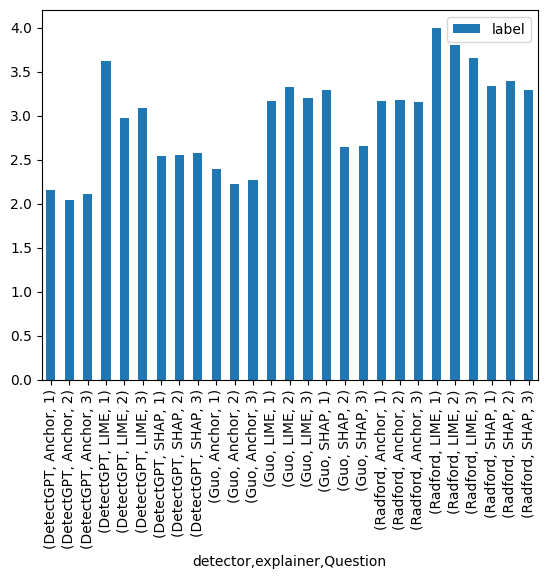

In [29]:
get_aggregate_results_lickert(["detector", "explainer", "question_nr"], "rating-group","Rating task at the group level")

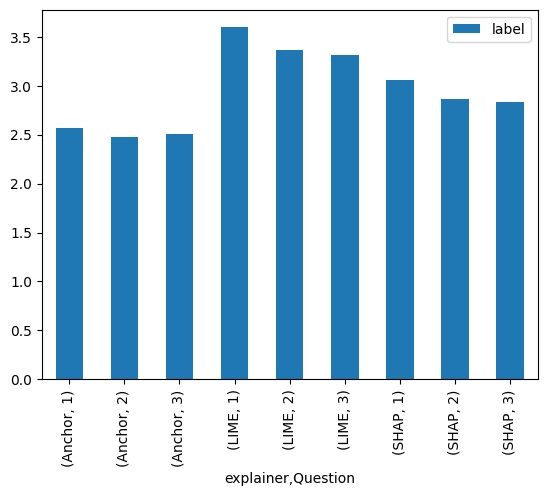

In [30]:
get_aggregate_results_lickert([ "explainer", "question_nr"], "lickert-explainer","Lickert Scale Items on explainer level")

In [31]:
with open("figures/tables_user_study.tex", "w", encoding="UTF-8") as text_file:
    text_file.write("\n".join(latex_output))